# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import  multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs


# Dataset creation

<Axes: xlabel='x coord', ylabel='y coord'>

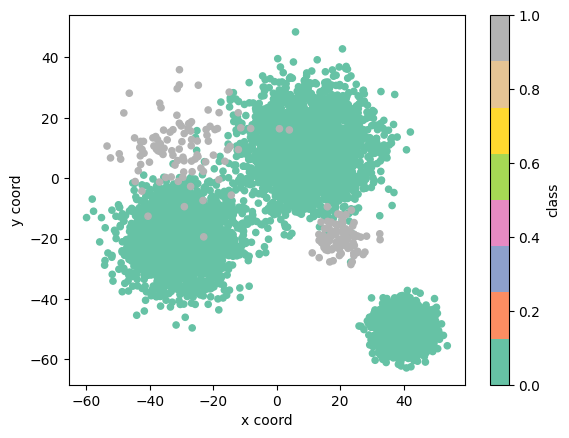

In [2]:
maj_centers = [[10,10],[-30,-20],[40,-50]]
min_centers = [[-30,10],[20,-20]]
maj_cov = [[[100,0],[0,100]],[[64,0],[0,64]],[[16,0],[0,16]]]
min_cov = [[[100,0],[0,100]],[[16,0],[0,16]]]
maj_std = [10, 8, 4]
min_std = [10, 4]

maj_samples = 7500
min_samples = 200

X, y = make_blobs(n_samples=maj_samples, centers= maj_centers, cluster_std=maj_std)

A, b = make_blobs(n_samples=min_samples, centers= min_centers, cluster_std=min_std)

 
blobs = pd.DataFrame()
blobs['x coord'] = X[:,0]
blobs['y coord'] = X[:,1]
blobs['class'] = 0
blobs1 = pd.DataFrame()
blobs1['x coord'] = A[:,0]
blobs1['y coord'] = A[:,1]
blobs1['class'] = 1
blobs = pd.concat([blobs, blobs1], axis=0)
blobs = blobs.reset_index(drop=True)
blobs.plot.scatter(x='x coord', y='y coord', c='class', cmap='Set2')


# Blob Experiments

In [ ]:
DATANAME = 'toy'
METHOD = 'forestflow'
TARGET = 'class'

In [3]:
forestcond = pd.read_csv(f'../data/{DATANAME}/{METHOD}/syn_ord.csv')
forestno_cond = pd.read_csv(f'../data/{DATANAME}/{METHOD}/syn_no_ord.csv')
forestcond

,x coord,y coord,cond
0,19.018499,2.765346,0.0
1,21.284774,10.598576,0.0
2,-26.506133,-19.310229,0.0
3,15.219161,-20.636123,2.0
4,40.159009,-50.476937,0.0
...,...,...,...
38495,40.286287,-45.967187,0.0
38496,40.189645,-53.333802,0.0
38497,40.040372,-50.473000,0.0
38498,-35.863625,-13.471005,0.0


In [4]:
# class is 1 if cond is 2, else class is 0
forestcond['class'] = forestcond['cond'].apply(lambda x: 1 if x == 2 else 0)
print(forestcond['class'].value_counts())
print(forestno_cond['class'].value_counts())

class
0    37454
1     1046
Name: count, dtype: int64
class
0.0    37450
1.0     1050
Name: count, dtype: int64


# Naive bayes classifier

In [5]:
# set params of gmm0

gmm0 = GaussianMixture(n_components=3, random_state=42)
gmm0.means_ = np.array(maj_centers)
gmm0.covariances_ = np.array(maj_cov)
gmm0.weights_ = np.array([1/3,1/3,1/3])

gmm1 = GaussianMixture(n_components=2, random_state=42)
gmm1.means_ = np.array(min_centers)
gmm1.covariances_ = np.array(min_cov)
gmm1.weights_ = np.array([1/2,1/2])


In [7]:
#  Define a function to compute the Gaussian PDF
def gaussian_pdf(x, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(x)

# Compute P(point | class=1) using the GMM
def compute_gmm_probability(point, weights, means, covariances):
    prob = 0
    for weight, mean, cov in zip(weights, means, covariances):
        prob += weight * gaussian_pdf(point, mean, cov)
    return prob

In [8]:
def compute_accuracy(df1):
    df = df1.copy()
  

    prior0 = maj_samples/(maj_samples+min_samples)
    prior1 = min_samples/(maj_samples+min_samples)
    # Compute the probabilities for all rows at once
    prob0 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm0.weights_, gmm0.means_, gmm0.covariances_) * prior0
    prob1 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm1.weights_, gmm1.means_, gmm1.covariances_) * prior1

    # Determine the predicted class
    predicted_class = (prob1 > prob0).astype(int)
    
    # Identify the rows where syn_class is 1 and predicted_class is 0
    condition = (df['class'] == 1) & (predicted_class == 0)
    condition2 = (df['class'] == 0) & (predicted_class == 1)

    # Count the number of such cases
    s1 = condition.sum()
    s2 = condition2.sum()


    maj = df[df['class']==0]
    min = df[df['class']==1]
    maj_acc = 1-len(df[condition2])/len(maj)
    min_acc = 1-len(df[condition])/len(min)
    print('Maj Acc.:', maj_acc)
    print('Min Acc.:', min_acc)
    print('Total Acc.:', 1-(len(df[condition2])+len(df[condition]))/len(df))
    

In [9]:
def mark_minority(df1):
    df = df1.copy()
    prior0 = maj_samples/(maj_samples+min_samples)
    prior1 = min_samples/(maj_samples+min_samples)
    
    # Compute the probabilities for all rows at once
    prob0 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm0.weights_, gmm0.means_, gmm0.covariances_) * prior0
    prob1 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm1.weights_, gmm1.means_, gmm1.covariances_) * prior1

    # Determine the predicted class
    predicted_class = (prob1 > prob0).astype(int)
    
    # Identify the rows where syn_class is 1 and predicted_class is 0
    condition = (df['class'] == 1) & (predicted_class == 0)
    
    # Count the number of such cases
    s = condition.sum()
    
    # Update the 'class' column based on the condition
    df.loc[condition, 'class'] = 2
    
    print(s)
    print(df['class'].value_counts())
    
    return df

    

In [10]:
def mark_minority_cond(df1):
    df = df1.copy()
    prior0 = maj_samples/(maj_samples+min_samples)
    prior1 = min_samples/(maj_samples+min_samples)
    
    # Compute the probabilities for all rows at once
    prob0 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm0.weights_, gmm0.means_, gmm0.covariances_) * prior0
    prob1 = compute_gmm_probability(df[['x coord', 'y coord']].values, gmm1.weights_, gmm1.means_, gmm1.covariances_) * prior1

    # Determine the predicted class
    predicted_class = (prob1 > prob0).astype(int)
    
    # Identify the rows where syn_class is 1 and predicted_class is 0
    condition = (df['class'] == 1) & (predicted_class == 0)
    
    # Count the number of such cases
    s = condition.sum()
    
    # Update the 'class' column based on the condition
    df.loc[condition, 'cond'] = 3 # 3 is the condition for misclassified minority class
    print(s)
    print(df['cond'].value_counts())
    
    return df

    

In [11]:

forestcond1 = mark_minority_cond(forestcond)


221
cond
0.0    36951
2.0      825
1.0      503
3.0      221
Name: count, dtype: int64


In [12]:

forestno_cond1 = mark_minority(forestno_cond)

203
class
0.0    37450
1.0      847
2.0      203
Name: count, dtype: int64


In [13]:

print('forest')
compute_accuracy(forestno_cond)
compute_accuracy(forestcond)



forest
Maj Acc.: 0.9964218958611482
Min Acc.: 0.8066666666666666
Total Acc.: 0.9912467532467533
Maj Acc.: 0.9978373471458322
Min Acc.: 0.7887189292543021
Total Acc.: 0.9921558441558441


In [14]:
forestcond['cond'].value_counts()

cond
0.0    36951
2.0     1046
1.0      503
Name: count, dtype: int64

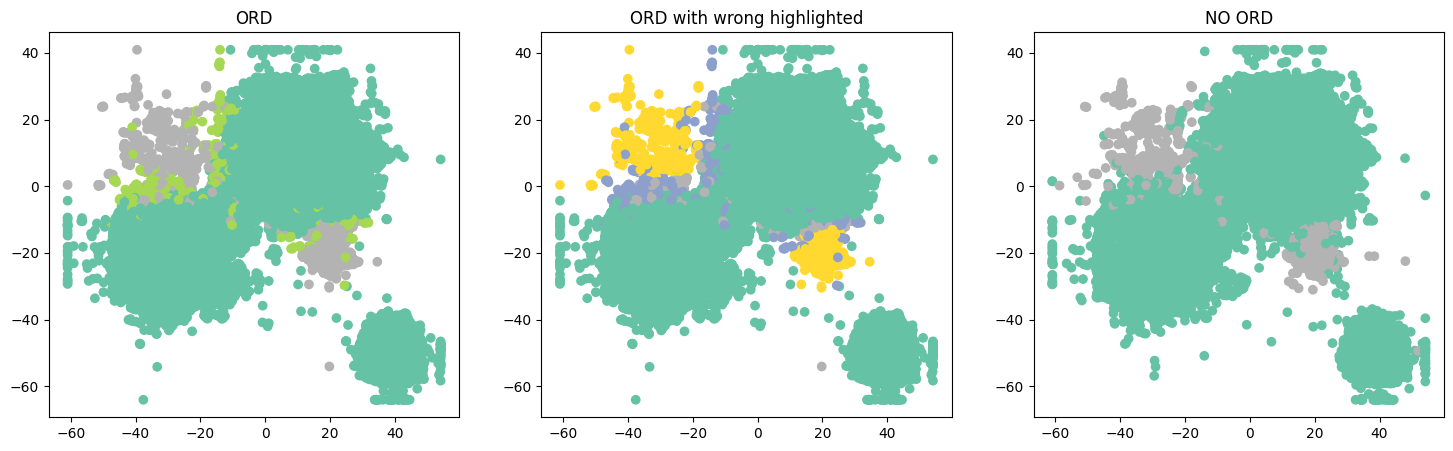

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].scatter(forestcond['x coord'], forestcond['y coord'], c=forestcond['cond'], cmap='Set2')
ax[0].set_title('ORD')
ax[1].scatter(forestcond1['x coord'], forestcond1['y coord'], c=forestcond1['cond'], cmap='Set2')
ax[1].set_title('ORD with wrong highlighted')
ax[2].scatter(forestno_cond['x coord'], forestno_cond['y coord'], c=forestno_cond['class'], cmap='Set2')
ax[2].set_title('NO ORD')



plt.show()


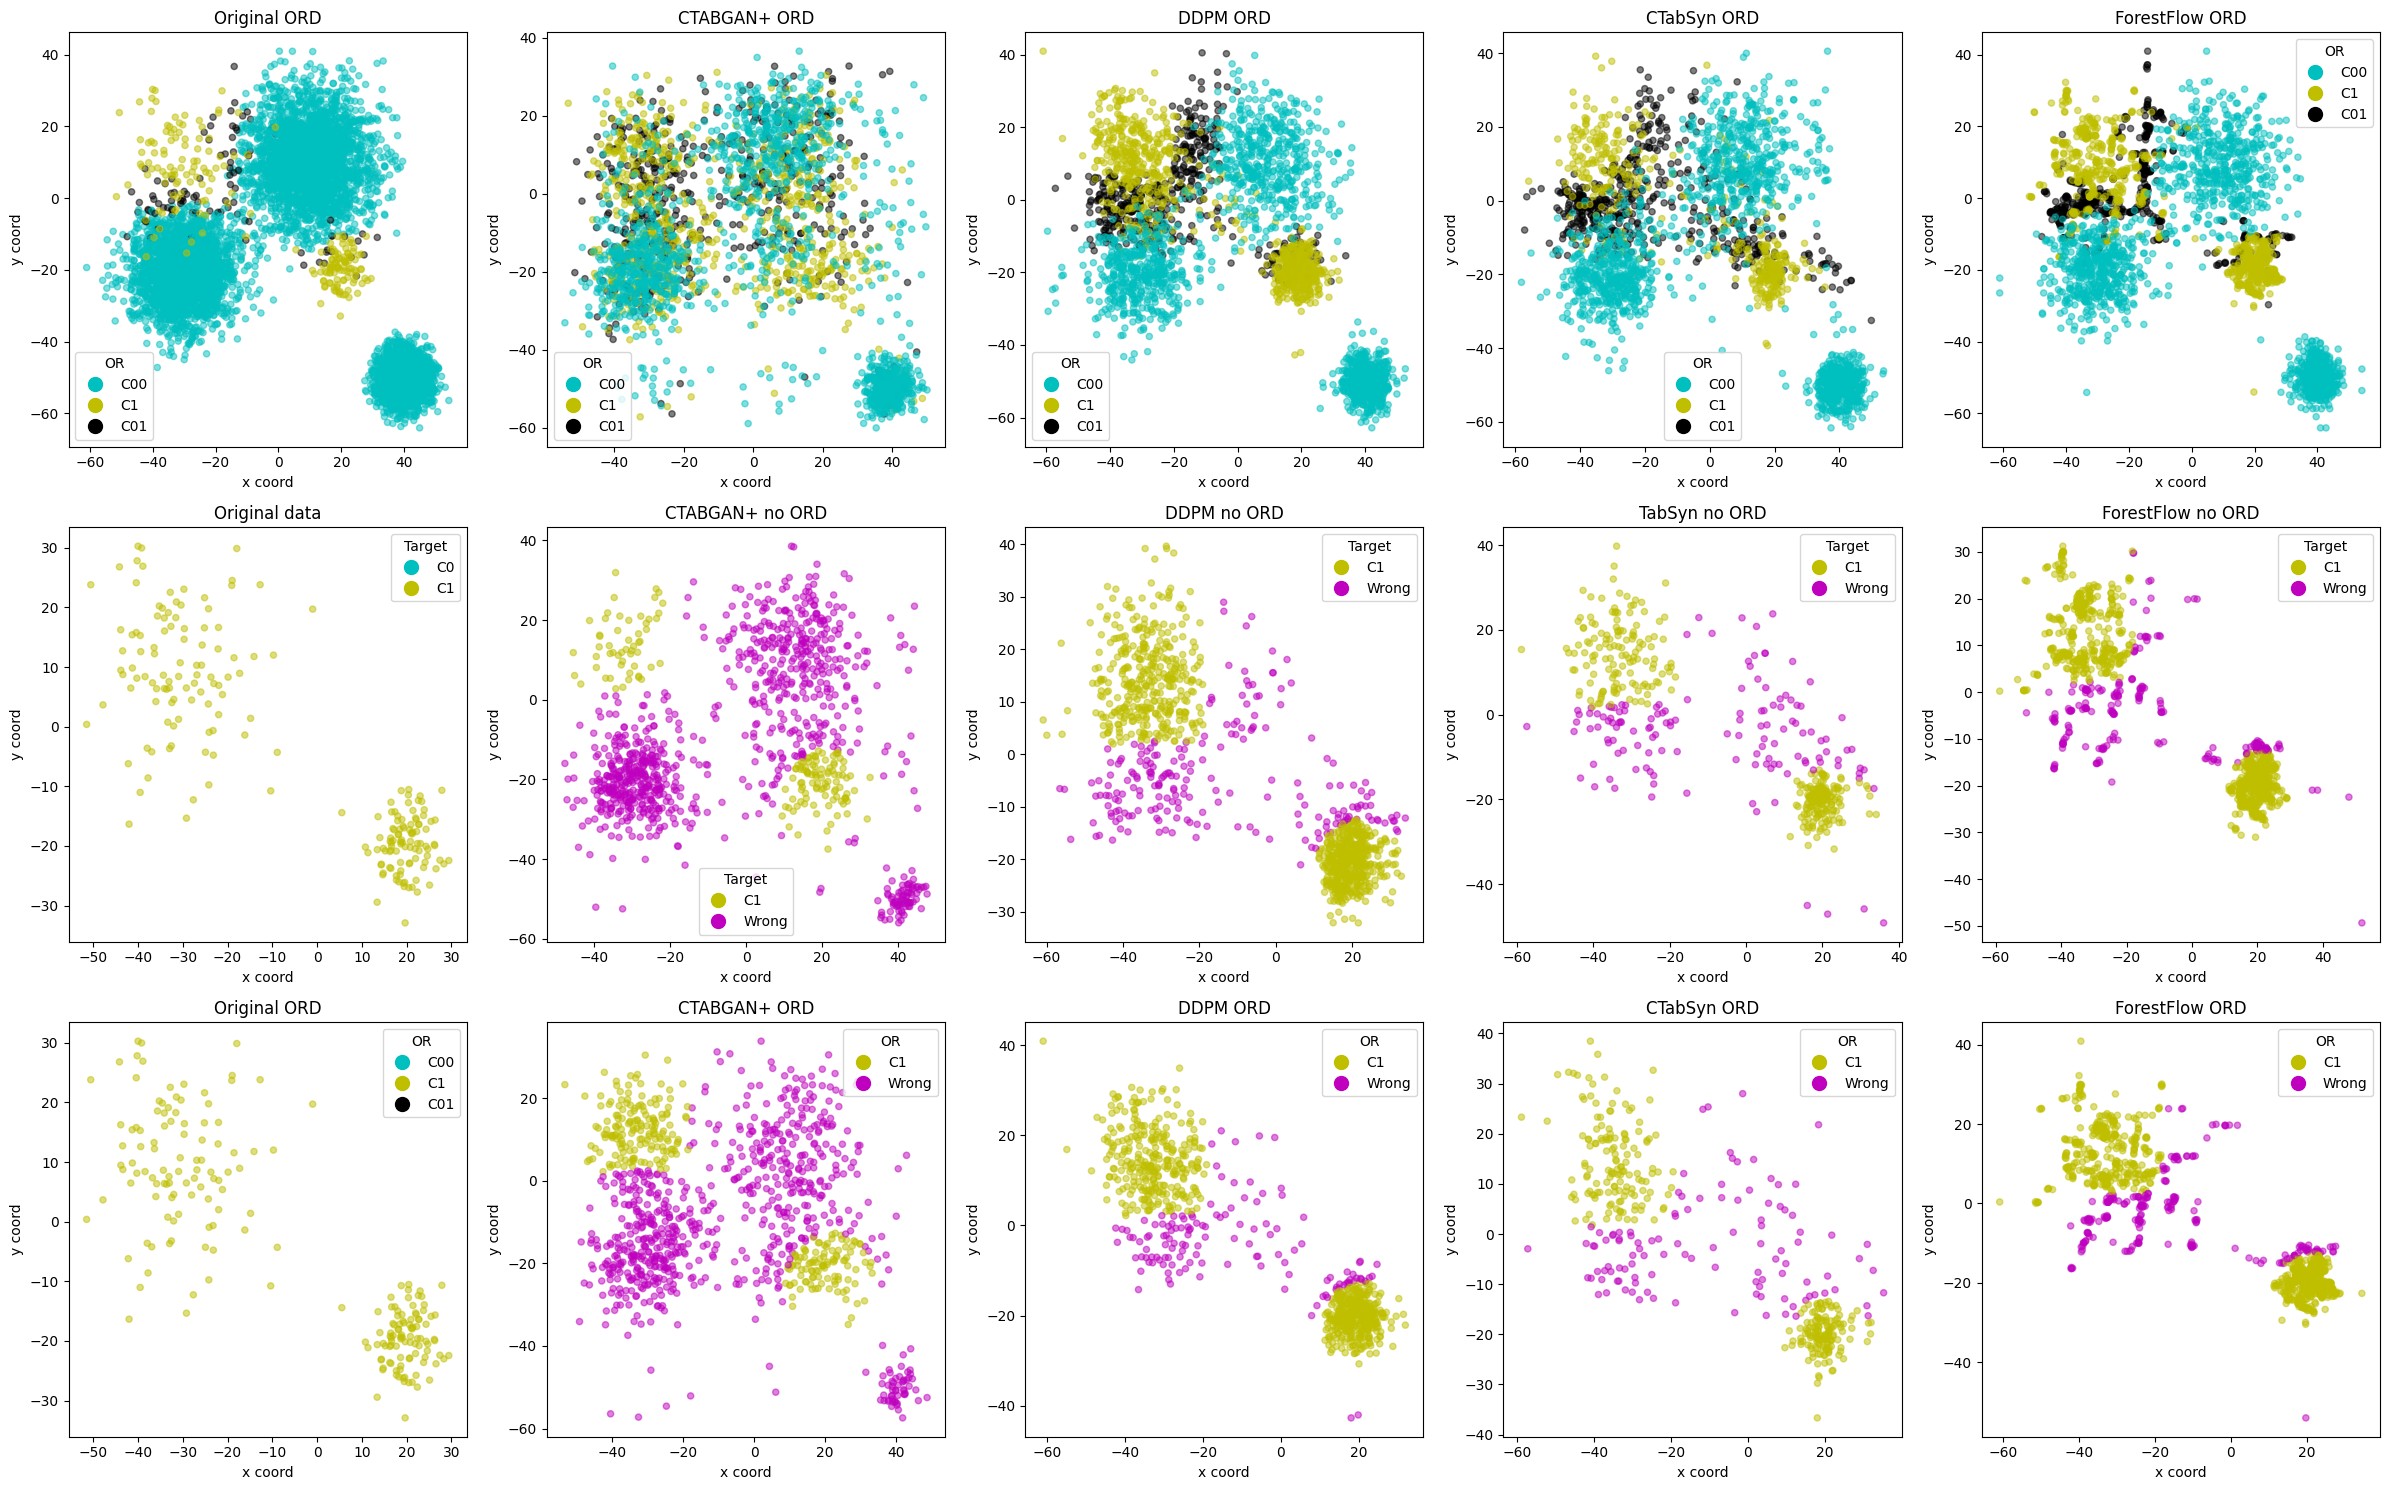